# Lesson 4. SimPy &mdash; Monitors

### SA421 Fall 2015

## From last time... 

**Problem.** Customers visit the neighborhood hair stylist Fantastic Dan for haircuts. The customer interarrival time is exponentially distributed with a mean of 20 minutes. Each haircut takes Fantastic Dan anywhere from 15 to 25 minutes, uniformly distributed. This time also includes the initial greetings and the transaction of money at the end of the haircut.

1. Simulate 1 day of Dan’s operations. Assume Dan works continuously for 6 hours a day.
2. How many customers enter Dan's shop per day?
3. How many customers does Dan serve per day?
4. What is the time average number of customers in the queue? What is the maximum number of customers in the queue? 
5. What is the average time spent by a customer in the queue (i.e. average delay)? What is the maximum?

* First, some setup code. 
    * This is mostly the same from before. 
    * Observe that there are some new lines to make plotting easy to do in IPython Notebook.

In [1]:
##### Setup #####
# Import everything from SimPy
from SimPy.Simulation import *

# Import seed initializer and random sampling functions from NumPy
from numpy.random import seed, uniform, exponential

# Import step plotting and histogram functions from Matplotlib
from matplotlib.pyplot import step, hist

# Run Matplotlib magic to show plots directly in the notebook
%matplotlib inline

# Make Matplotlib plots display as SVG files, which are cleaner
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

* Here is the simulation model for the Fantastic Dan problem from last time, modified to run for only 2 hours.

In [2]:
##### Parameters #####
class P:
    # Customers arrive at the entrance with exponentially distributed
    # interarrival times with mean 20
    interarrivalTimeMean = 20
    
    # Service times are uniformly distributed between 15 and 25
    serviceTimeMin = 15
    serviceTimeMax = 25
    
    # One server: Fantastic Dan works by himself
    nServers = 1
    
    # Shop is open for 2 continuous hours
    simulationTimeMax =  2 * 60
    

##### Processes #####
# Customer
class Customer(Process):
    def behavior(self):
        # Customer arrives, joins queue
        print("Time {1}: {0} arrives and joins queue".format(self.name, now()))
        yield request, self, R.server
        
        # Customer is released from queue and starts service
        print("Time {1}: {0} begins service".format(self.name, now()))
        serviceTime = uniform(low = P.serviceTimeMin, high = P.serviceTimeMax)
        yield hold, self, serviceTime
        
        # Customer finishes service, leaves
        print("Time {1}: {0} ends service and leaves".format(self.name, now()))
        yield release, self, R.server

# Entrance
class Entrance(Process):
    def behavior(self):
        # At the start of the simulation, no customers have arrived
        nCustomers = 0
        
        # Customer arrivals
        while True:
            # Wait until the next arrival
            interarrivalTime = exponential(scale = P.interarrivalTimeMean)
            yield hold, self, interarrivalTime
            
            # Create a new customer using the template defined in the Customer class
            c = Customer(name="Customer {0}".format(nCustomers))
            
            # Activate the customer's behavior
            activate(c, c.behavior())

            # Count this new customer
            nCustomers += 1

##### Resources #####
class R:
    # Server
    server = None


##### Model #####
def model():
    # Initialize SimPy 
    initialize()

    # Initialize a seed for the random number generator (more on this later in the semester)
    seed(123)

    # Create the server resource
    R.server = Resource(capacity = P.nServers)

    # Activate the entrance (to generate customers)
    e = Entrance()
    activate(e, e.behavior())
    
    # Run the simulation
    simulate(until = P.simulationTimeMax)

* Running the model, we see output similar to what we had last time.

In [3]:
model()

Time 23.84544286962211: Customer 0 arrives and joins queue
Time 23.84544286962211: Customer 0 begins service
Time 30.58679252313273: Customer 1 arrives and joins queue
Time 41.113957405264145: Customer 0 ends service and leaves
Time 41.113957405264145: Customer 1 begins service
Time 46.615466159426475: Customer 2 arrives and joins queue
Time 57.617416875006015: Customer 3 arrives and joins queue
Time 63.308647103119775: Customer 1 ends service and leaves
Time 63.308647103119775: Customer 2 begins service
Time 85.1569444889684: Customer 2 ends service and leaves
Time 85.1569444889684: Customer 3 begins service
Time 104.96626350381202: Customer 3 ends service and leaves


* Based on our 1 simulation run, Dan cuts hair for 4 customers by the end of the day, and has 4 customers enter his shop.


* To compute the time average number of customers in the queue, we can use a monitor.

## What is a monitor?

* A **monitor** enables us to observe a variable of interest and hold a time series of its values.


* Monitoring certain aspects of a resource in SimPy is quite easy:
    - the number of entities in the resource's queue
    - the number of entities being processed by the resource
    

* Monitoring other quantities in SimPy requires a little more work, but is still pretty easy.

## Built-in monitors for resources

* We can activate the built-in monitors for a resource by adding the argument `monitored = True` when we call `Resource()` to create the resource.


* Doing this establishes two monitors:
    * **`waitMon`** to record changes in the queue.
    * **`actMon`** to record changes in entities being served.


* Let's modify `model()` from our Fantastic Dan simulation to activate these monitors for the server.

In [4]:
##### Model #####
def model():
    # Initialize SimPy 
    initialize()

    # Initialize a seed for the random number generator (more on this later in the semester)
    seed(123)

    # Create the server resource
    R.server = Resource(capacity = P.nServers, monitored = True)

    # Activate the entrance (to generate customers)
    e = Entrance()
    activate(e, e.behavior())
    
    # Run the simulation
    simulate(until = P.simulationTimeMax)

* Now, let's run the model.

In [5]:
##### Experiment #####
model()

Time 23.84544286962211: Customer 0 arrives and joins queue
Time 23.84544286962211: Customer 0 begins service
Time 30.58679252313273: Customer 1 arrives and joins queue
Time 41.113957405264145: Customer 0 ends service and leaves
Time 41.113957405264145: Customer 1 begins service
Time 46.615466159426475: Customer 2 arrives and joins queue
Time 57.617416875006015: Customer 3 arrives and joins queue
Time 63.308647103119775: Customer 1 ends service and leaves
Time 63.308647103119775: Customer 2 begins service
Time 85.1569444889684: Customer 2 ends service and leaves
Time 85.1569444889684: Customer 3 begins service
Time 104.96626350381202: Customer 3 ends service and leaves


* Everything looks the same as before, but...


* Now, we can access a resource's monitors using `.waitMon` and `.actMon`.


* For example, to examine `waitMon` for `R.server`, we can write:

In [6]:
print("waitMon for R.server: {0}".format(R.server.waitMon))

waitMon for R.server: [[0, 0], [30.58679252313273, 1], [41.113957405264145, 0], [46.615466159426475, 1], [57.617416875006015, 2], [63.308647103119775, 1], [85.1569444889684, 0]]


* As we can see, this monitor is a list of lists.


* Comparing `waitMon` with the output of the simulation, we see that the "inner lists" are observations of the form $[t, y]$, where

$$\begin{aligned}
t & = \text{time}\\
y & = \text{length of queue at time $t$}
\end{aligned}$$

* `actMon` works in a similar fashion:

In [7]:
print("actMon for R.server: {0}".format(R.server.actMon))

actMon for R.server: [[0, 0], [23.84544286962211, 1], [41.113957405264145, 0], [41.113957405264145, 1], [63.308647103119775, 0], [63.308647103119775, 1], [85.1569444889684, 0], [85.1569444889684, 1], [104.96626350381202, 0]]


* Now, `actMon` consists of data points of the form $[t, y]$, where

$$\begin{aligned}
t & = \text{time}\\
y & = \text{number of entities being processed by the resource at time $t$}
\end{aligned}$$

* To make these monitors easier to work with, we can split them into two lists:
    - One list consisting of the times $t$
    - Another list consisting of the values $y$


* For example, to get separate lists of the times and values of `waitMon`, we can write:

In [8]:
print("waitMon times = {0}".format(R.server.waitMon.tseries()))
print("waitMon values = {0}".format(R.server.waitMon.yseries()))

waitMon times = (0, 30.58679252313273, 41.113957405264145, 46.615466159426475, 57.617416875006015, 63.308647103119775, 85.1569444889684)
waitMon values = (0, 1, 0, 1, 2, 1, 0)


* With these separate lists, we can plot the number of customers in the queue as a function of time using the `step` function from Matplotlib


* `step(t, y, where = "post")` creates a step plot: 
    - `t` is a list of the horizontal axis breakpoints, assumed to be in nondecreasing order
    - `y` is a list of the corresponding vertical axis values
    - `where = "post"` tells `step` to assign the interval between `t[i]` and `t[i+1]` a value of `y[i]`.
    - [Matplotlib documentation on `step` &mdash; scroll to find `matplotlib.pyplot.step`](http://matplotlib.org/api/pyplot_api.html)

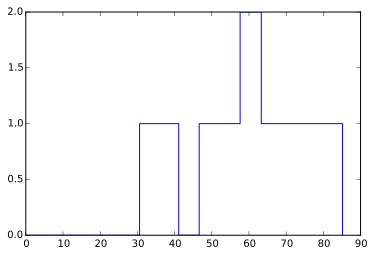

In [9]:
step(R.server.waitMon.tseries(), R.server.waitMon.yseries(), where = "post")

* We can also easily get some summary statistics from these monitors, such as 
    * the time average number of customers in the queue, and 
    * the maximum number of customers in the queue.

In [10]:
# Get average number of customers waiting for a haircut
print("Time average number of customers in queue = {0}".format(R.server.waitMon.timeAverage()))

# Get maximum number of customers waiting for a haircut
print("Maximum number of customers in queue = {0}".format(max(R.server.waitMon.yseries())))

Time average number of customers in queue = 0.45633227866489257
Maximum number of customers in queue = 2


* Other summary statistics of interest for a monitor named `monitor`:
    - `monitor.count()` gives the current number of observations
    - `monitor.total()` gives the sum of the $y$ values
    - `monitor.mean()` gives the average of the $y$ values, <span style="color:#a00000">ignoring the corresponding times of the $y$ values</span>
    - `monitor.var()` gives the sample variance of the y values, <span style="color:#a00000">ignoring the corresponding times of the $y$ values</span>
    
    
* [Here](http://simpy.sourceforge.net/old/SimPy_Manual/Manuals/Manual.html#data-summaries) is the SimPy documentation on summary statistics available for a monitor.

## Custom-made monitors

* To figure out how long a customer waits in the queue on average (i.e. average delay), we need to monitor the customer behavior directly.


* This can be accomplished using a custom-made monitor.


* Like with parameters and resources, we define variables for monitors in a common class.

In [11]:
##### Monitors #####
class M:
    delay = None

* Also like with resources, we create the monitor after we initialize the simulation.

In [12]:
##### Model #####
def model():
    # Initialize SimPy 
    initialize()

    # Initialize a seed for the random number generator (more on this later in the semester)
    seed(123)

    # Create the server resource
    R.server = Resource(capacity = P.nServers, monitored = True)
    
    # Create the delay monitor
    M.delay = Monitor()

    # Activate the entrance (to generate customers)
    e = Entrance()
    activate(e, e.behavior())
    
    # Run the simulation
    simulate(until = P.simulationTimeMax)

* We need to modify the behavior of the `Customer` process to monitor the delay (i.e. time in queue) of each customer.


* For a monitor named `monitor`, we use `monitor.observe(value)` to record `value` at the current time of the simulation.

In [13]:
# Customer
class Customer(Process):
    def behavior(self):
        # Customer arrives, joins queue
        arrivalTime = now()
        print("Time {1}: {0} arrives and joins queue".format(self.name, now()))
        yield request, self, R.server
        
        # Customer released from queue, starts haircut
        delay = now() - arrivalTime
        M.delay.observe(delay)
        print("Time {1}: {0} begins service".format(self.name, now()))
        serviceTime = uniform(low = P.serviceTimeMin, high = P.serviceTimeMax)
        yield hold, self, serviceTime
        
        # Customer finishes haircut, leaves
        print("Time {1}: {0} ends service and leaves".format(self.name, now()))
        yield release, self, R.server

* Now, we can run the model again, with the delay monitor.

In [14]:
##### Experiment #####
model()

Time 23.84544286962211: Customer 0 arrives and joins queue
Time 23.84544286962211: Customer 0 begins service
Time 30.58679252313273: Customer 1 arrives and joins queue
Time 41.113957405264145: Customer 0 ends service and leaves
Time 41.113957405264145: Customer 1 begins service
Time 46.615466159426475: Customer 2 arrives and joins queue
Time 57.617416875006015: Customer 3 arrives and joins queue
Time 63.308647103119775: Customer 1 ends service and leaves
Time 63.308647103119775: Customer 2 begins service
Time 85.1569444889684: Customer 2 ends service and leaves
Time 85.1569444889684: Customer 3 begins service
Time 104.96626350381202: Customer 3 ends service and leaves


* We can examine the delay of each customer that we recorded using this monitor:

In [15]:
# Print customer delay and the time of recording
print("Time recorded = {0}".format(M.delay.tseries()))
print("Delay = {0}".format(M.delay.yseries()))

Time recorded = (23.84544286962211, 41.113957405264145, 63.308647103119775, 85.1569444889684)
Delay = (0.0, 10.527164882131416, 16.6931809436933, 27.53952761396239)


* Finally, we can compute the average and maximum delay:

In [16]:
# Get average delay
print("Average delay = {0}".format(M.delay.mean()))

# Get maximum delay
print("Maximum delay = {0}".format(max(M.delay.yseries())))

Average delay = 13.689968359946777
Maximum delay = 27.53952761396239


* While we're at it, we can plot a histogram of the customer delay using the `hist` function from Matplotlib.


* `hist(x, bins)` creates a histogram
    - `x` is a list of data points
    - `bins` is a list of the edges of the bin intervals
    - Without any other arguments, `hist` automatically creates bins for the histogram
    - [Here](http://matplotlib.org/api/pyplot_api.html) is the Matplotlib documentation for `hist` &ndash; scroll down to find `matplotlib.pyplot.hist`

(array([ 1.,  2.,  1.]), array([ 0, 10, 20, 30]), <a list of 3 Patch objects>)

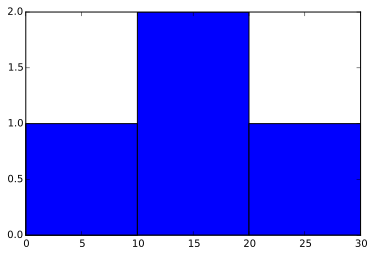

In [17]:
# Define edges of the histogram bin intervals
bins = [0, 10, 20, 30]

# Get histogram of customer time in queue
hist(M.delay.yseries(), bins)

## On your own...

* First, change the simulation to run for 6 hours instead of 2.


* Since we defined the class `P` above, we do not need to redefine the entire class `P` &ndash; we can just redefine `P.simulationTimeMax` by itself:

In [18]:
P.simulationTimeMax = 6 * 60

* In the Fantastic Dan problem, since there is only 1 server, the time average number of busy servers gives you the server utilization: the fraction of time the server is busy.


* Given what we learned today, how can you compute the time average number of busy servers?

<span style="color:#000080">First, run the simulation again, now for 6 hours instead of 2.</span>

In [19]:
model()

Time 23.84544286962211: Customer 0 arrives and joins queue
Time 23.84544286962211: Customer 0 begins service
Time 30.58679252313273: Customer 1 arrives and joins queue
Time 41.113957405264145: Customer 0 ends service and leaves
Time 41.113957405264145: Customer 1 begins service
Time 46.615466159426475: Customer 2 arrives and joins queue
Time 57.617416875006015: Customer 3 arrives and joins queue
Time 63.308647103119775: Customer 1 ends service and leaves
Time 63.308647103119775: Customer 2 begins service
Time 85.1569444889684: Customer 2 ends service and leaves
Time 85.1569444889684: Customer 3 begins service
Time 104.96626350381202: Customer 3 ends service and leaves
Time 136.63705825130037: Customer 4 arrives and joins queue
Time 136.63705825130037: Customer 4 begins service
Time 146.5925322953354: Customer 5 arrives and joins queue
Time 155.06883841280907: Customer 4 ends service and leaves
Time 155.06883841280907: Customer 5 begins service
Time 172.70893023548854: Customer 6 arrive

<span style="color:#000080">Remember that `actMon` records the number of entities being processed by a resource at any given time.</span>

<span style="color:#000080">Therefore, `R.server.actMon` records how the number of busy servers changes over time, and so we want the time average of the time series recorded by this monitor.</span>

In [20]:
print("Time average number of busy servers = {0}".format(R.server.actMon.timeAverage()))

Time average number of busy servers = 0.8457882288413597


* Create a monitor that records a value for each customer that enters the shop: 
    - 1 if a customer waits in the queue for more than 15 minutes, 
    - 0 otherwise.


* Using this monitor, find the fraction of customers that wait in the queue for more than 15 minutes.

<span style="color:#000080">First, we create a dummy variable for this new monitor. We'll call it `M.delayMore15`.</span>

<span style="color:#000080">Again, since we already defined the class `M`, we do not need to define the entire class again &ndash; we can just define `M.delayMore15` by itself.</span>

In [21]:
# Define dummy variable for a new monitor
M.delayMore15 = None

<span style="color:#000080">Next, before running the simulation model, we need to actually create the new monitor: see the line marked by `#2`.</span>

In [22]:
# Modify model to create monitor
def model():
    # Initialize SimPy 
    initialize()

    # Initialize a seed for the random number generator (more on this later in the semester)
    seed(123)

    # Create the server resource
    R.server = Resource(capacity = P.nServers, monitored = True)
    
    # Create the queue wait time monitor
    M.delay = Monitor()
    
    # Create monitor to record whether queue wait time is more than 15 minutes
    M.delayMore15 = Monitor()        #2
    
    # Activate the entrance (to generate customers)
    e = Entrance()
    activate(e, e.behavior())
    
    # Run the simulation
    simulate(until = P.simulationTimeMax)

<span style="color:#000080">Finally, we need to modify the `Customer` process to record whether the customer delay is more than 15 minutes: see the `if-else` clause starting at the line marked by `#1`.</span>

In [23]:
# Modify Customer process to record whether a customer
# is in the queue for more than 15 minutes
class Customer(Process):
    def behavior(self):
        # Customer arrives, joins queue
        arrivalTime = now()
        print("Time {1}: {0} arrives and joins queue".format(self.name, now()))
        yield request, self, R.server
        
        # Customer released from queue, starts haircut
        delay = now() - arrivalTime
        M.delay.observe(delay)
        
        if delay > 15:            #1
            delayMore15 = 1
        else:
            delayMore15 = 0
        M.delayMore15.observe(delayMore15)
        
        print("Time {1}: {0} begins service".format(self.name, now()))
        serviceTime = uniform(low = P.serviceTimeMin, high = P.serviceTimeMax)
        yield hold, self, serviceTime
        
        # Customer finishes haircut, leaves
        print("Time {1}: {0} ends service and leaves".format(self.name, now()))
        yield release, self, R.server

<span style="color:#000080">Now, we can run the model.</span>

In [24]:
# Run new model
model()

Time 23.84544286962211: Customer 0 arrives and joins queue
Time 23.84544286962211: Customer 0 begins service
Time 30.58679252313273: Customer 1 arrives and joins queue
Time 41.113957405264145: Customer 0 ends service and leaves
Time 41.113957405264145: Customer 1 begins service
Time 46.615466159426475: Customer 2 arrives and joins queue
Time 57.617416875006015: Customer 3 arrives and joins queue
Time 63.308647103119775: Customer 1 ends service and leaves
Time 63.308647103119775: Customer 2 begins service
Time 85.1569444889684: Customer 2 ends service and leaves
Time 85.1569444889684: Customer 3 begins service
Time 104.96626350381202: Customer 3 ends service and leaves
Time 136.63705825130037: Customer 4 arrives and joins queue
Time 136.63705825130037: Customer 4 begins service
Time 146.5925322953354: Customer 5 arrives and joins queue
Time 155.06883841280907: Customer 4 ends service and leaves
Time 155.06883841280907: Customer 5 begins service
Time 172.70893023548854: Customer 6 arrive

<span style="color:#000080">To determine the fraction of customers with delay more than 15 minutes, we can simply take the mean of the $y$ values of the `M.delayMore15` monitor. (Why can we do this?)</span>

In [25]:
# Find the fraction of customers with delay more than 15 minutes
print("Fraction of customers with delay more than 15 minutes = {0}".format(M.delayMore15.mean()))

Fraction of customers with delay more than 15 minutes = 0.6875
